# Project Topic 7

Authors: 
* Philipp Bonny (3761754)
* Benjamin Jung (3761649)
* Peter Klein (3761266)

## Data

The data for this project comes from New York Stock Exchange. The dataset was originally released
on Kaggle and, among other information, contains several years of daily stock prices for S&P 500
companies. The dataset is available from Moodle. For more detailed information about it, please
refer to its original description on Kaggle.

## Goal

The goal of this project is to predict the price of a stock for the next day, one week into the future, or one month into the future. This is a problem for which many traditional time-series analysis methods
exist (e.g., exponential smoothing), but which can also be addressed using recurrent neural
networks (e.g., LSTMs or GRUs).

## Ideas and Suggestions

* First, you need to familiarize yourself with the dataset and make sure that you understand the
different values in it and its particularities.

* Second, you should identify suitable baseline methods. These include traditional time-series
analysis methods (e.g., exponential smoothing and time-series decomposition). Note that you
do not have to implement those yourselves, but you can rely on existing implementations.
Also, consider having a look at Prophet as a general-purpose time-series prediction library
developed at facebook.

* Third, you should think about your own approach(es). One idea is to apply a form of recurrent
neural network (e.g., LSTM or GRU) to a time series in isolation, viewing it as a sequence of
numerical values. As a variant, you may consider taking additional information (e.g., the time
series belonging to other stocks) into account. The goal should always be to predict the price
of an individual stock, but you can vary how much additional information you consider.

* For the evaluation, you should compare the different approaches in terms of a suitable quality
measure (e.g., mean absolute error), consider different time periods, and vary how much historical data is taken into account.

## In this project
We will use the metric of mean sqared error to compare different approaches. 

* Simple Exponential Smoothing (SES)
* Facebook Prophet
* 


# Import Libraries

In [32]:
import os
import pandas as pd

# LSTM
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN, GRU
print(tf.__version__)


# we need to use numpy=1.19 to be compatible with tensorflow version
import numpy as np

# Plot Graphs
import matplotlib.pyplot as plt

# Calculate Dates
import datetime
import matplotlib.dates as mdates

# We use the sklearn lib to split the data into test/train data
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Simple Exponential Smoothing (SES)
from statsmodels.tsa.api import SimpleExpSmoothing 

# Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Deactivate GPU usage by tensorflow because CPU is faster in our cases
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2.3.0


# Configurations
ticker_name defines the name of the stock that should be trained and predicted on 

In [2]:
ticker_name = 'AAPL'

# Predefined Functions


In [3]:
def plot_graph(title, actual_date_df, actual_value_df):
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_title(title)

    ax1.plot(actual_date_df, actual_value_df, color='green', label='Actual')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Year')
    plt.legend()
    plt.show()
    return

def plot_comparison_graph(title, actual_date_df, actual_value_df, predicted_date_df, predicted_value_df):
    fig = plt.figure(figsize = (10,6))
    ax1 = fig.add_axes([0,0,1,1])
    ax1.set_title(title)

    actual_date_df_converted = pd.to_datetime(actual_date_df, format = '%Y-%m-%d')
    predicted_date_df_converted = pd.to_datetime(predicted_date_df, format = '%Y-%m-%d')
    
    ax1.plot(actual_date_df, actual_value_df, color='green', label='Actual')
    ax1.plot(predicted_date_df,predicted_value_df, color='red', label='Predicted')

    ax1.set_ylabel('Price')
    ax1.set_xlabel('Year')
    plt.legend()
    plt.show()
    return
    
def show_comparison_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    return
    
def predict_prophet(prophet_data, days_to_predict):
    # Grap stock data to predict a month in the future
    train = prophet_data.drop(prophet_data.index[-days_to_predict:])
    init_test = prophet_data[-days_to_predict:]

    # Future defines the days/dates that will be predicted
    future = pd.DataFrame(init_test['ds'])

    # Start training the model with the testdata
    model = Prophet(daily_seasonality=False)
    model.fit(train)

    # make a prediction with the testdata for the last 31 days of data we have
    prophet_prediction = model.predict(future)
    return init_test, prophet_prediction

# Read Stock Data

First, we will read the existing stock prices of the S&P500 index from the csv file into a dataframe. We will use the adjusted price history. This takes into account dividends, stock splits and other factors that may have affected the price.

In [4]:
# Read complete csv file of stocks
sp500 = pd.read_csv('data/prices-split-adjusted.csv') 

# Filter dataframe by ticker_name
stock_df = sp500[sp500['symbol'] == ticker_name].copy(deep=False)

# Convert Date to panda DateTime
stock_df['date'] = pd.to_datetime(stock_df['date'], format = '%Y-%m-%d')

stock_df

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0
...,...,...,...,...,...,...,...
848767,2016-12-23,AAPL,115.589996,116.519997,115.589996,116.519997,14249500.0
849267,2016-12-27,AAPL,116.519997,117.260002,116.489998,117.800003,18296900.0
849767,2016-12-28,AAPL,117.519997,116.760002,116.199997,118.019997,20905900.0
850267,2016-12-29,AAPL,116.449997,116.730003,116.400002,117.110001,15039500.0


In [5]:
# We prepare the dataframe so we can use it for training
# therefore we select the Date and Closing Price
stock_df_date_close = stock_df[["date", "close"]]
stock_df_complete = stock_df[["date", "close", "open", "low", "high", "volume"]]
stock_df_date_close

,date,close
254,2010-01-04,30.572857
721,2010-01-05,30.625713
1189,2010-01-06,30.138571
1657,2010-01-07,30.082857
2125,2010-01-08,30.282858
...,...,...
848767,2016-12-23,116.519997
849267,2016-12-27,117.260002
849767,2016-12-28,116.760002
850267,2016-12-29,116.730003


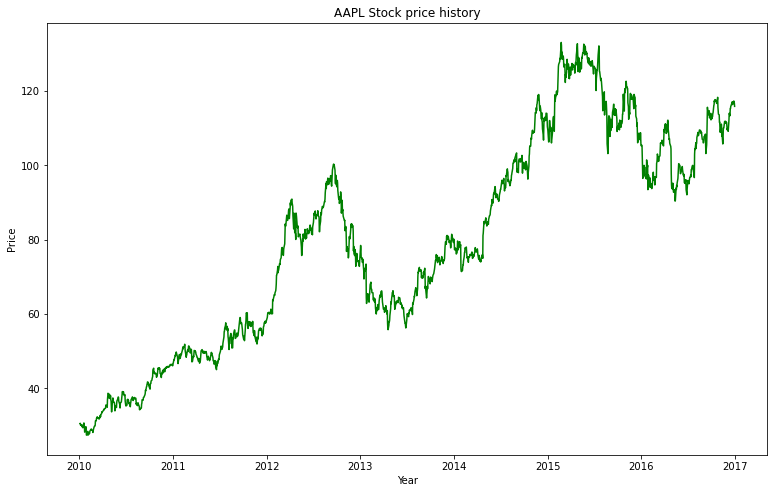

In [6]:
# Print History Stock prices
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_axes([0,0,1,1])
ax1.set_title(ticker_name + ' Stock price history')

ax1.plot(stock_df['date'],
         stock_df['close'],
         color='green')

ax1.set_ylabel('Price')
ax1.set_xlabel('Year')

plt.show()

# Simple Exponential Smoothing (SES)

TODO: Erklärung SES -> https://analyticsindiamag.com/hands-on-guide-to-time-series-analysis-using-simple-exponential-smoothing-in-python/
Definitionen?: https://sailajakarra.medium.com/time-series-analysis-using-python-and-pandas-49b806d2acf3


Also 2 Ansätze einmal alpha manuell und einmal vom system bestimmt
Wir prüfen hier 31 Tage in die zukunft
Hierfür mussten wir die fehlenden daten im datensatz erweitern
der graph zeigt beide vorhersagen des models

In [7]:
ses_data = stock_df_date_close.copy(deep=False)
ses_data.columns = ['ds','y']

ses_data_fitted = pd.Series(ses_data['y'].values, ses_data['ds'].values)

# Fill missing dates for SES (weekends while stock market is closed)
ses_data_fitted = ses_data_fitted.resample('D').ffill()

# We need to set the index frequency
ses_data_fitted.index = pd.DatetimeIndex(ses_data_fitted.index).to_period('D')

# Split the data so we compare the prediction against the actual value
# Grap stock data to predict a month in the future
ses_train = ses_data_fitted.drop(ses_data_fitted.index[-30:])
ses_test = ses_data_fitted[-30:]

D:\Software\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
D:\Software\anaconda3\envs\tf\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


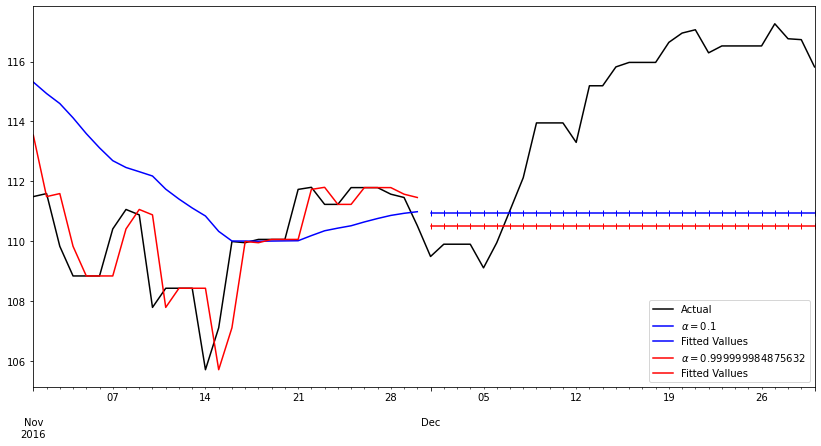

MSE for Prediction 1 with α=0.1 is: 19.012
MSE for Prediction 2 with α=0.999999984875632 is: 22.036


In [8]:
ses_data_fitted[-60:].plot(color='black', legend=True, figsize=(14, 7), label="Actual") 
    
ses_fit_1 = SimpleExpSmoothing(ses_train).fit(smoothing_level=0.1,optimized=False)
predict_fit_1 = ses_fit_1.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha={}$'.format(0.1))

# specific smoothing level
predict_fit_1.plot(marker="|",  color='blue', legend=True)
ses_fit_1.fittedvalues[-30:].plot(color='blue', legend=True, label="Fitted Vallues")

## auto optimization
ses_fit_2 = SimpleExpSmoothing(ses_train).fit()
predict_fit_2 = ses_fit_2.predict(ses_test.index.min(), ses_test.index.max()).rename(r'$\alpha=%s$'%ses_fit_2.model.params['smoothing_level'])

# plot
predict_fit_2.plot(marker="|", color='red', legend=True)
ses_fit_2.fittedvalues[-30:].plot(color='red', legend=True, label="Fitted Vallues")
     
plt.show()

#mse1 = ((predict_fit_1 - ses_test) ** 2).mean()
#print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(0.2,round(np.sqrt(mse1), 2)))

mse = mean_squared_error(ses_test.values, predict_fit_1.values)
print('MSE for Prediction 1 with \u03B1=0.1 is: %.3f' % mse)

mse2 = mean_squared_error(ses_test.values, predict_fit_2.values)
print('MSE for Prediction 2 with \u03B1=%s is: %.3f' % (ses_fit_2.model.params['smoothing_level'] , mse2))

# Facebook Prophet


In [9]:
# We need to rename the columns in order for Prophet to understand the data
prophet_data = stock_df_date_close.copy(deep=False)
prophet_data.columns = ['ds','y']

train, init_test = train_test_split(prophet_data, test_size=0.1, shuffle = False)

# Select only the dates for the test-set
test = pd.DataFrame(init_test['ds'])

# Start training the model with the testdata
model = Prophet(daily_seasonality=False)
model.fit(train)

# make a prediction with the testdata
prophet_prediction = model.predict(test)

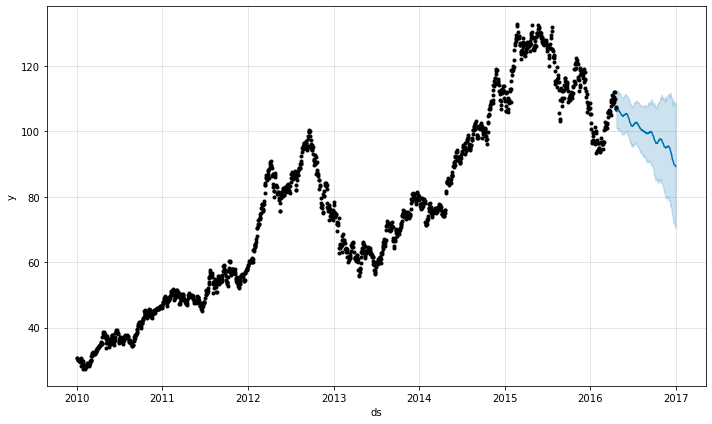

In [10]:
model.plot(prophet_prediction);

This plot shows a trend estimate of the prophet model. If we compare this graph to the real price history of the underlying stock we can see that the actual value did not decrease as much as the model predicted. It followed a downwards trend while the actual stock price stagnated and did not decrase like forecasted. To analyse the prediction we will focus on a prediction of 31 days in the next example. Here we will calculate the MEA and plot the difference between the actual and dorcasted stock chart for this specific timeframe.


MSE: 178.044


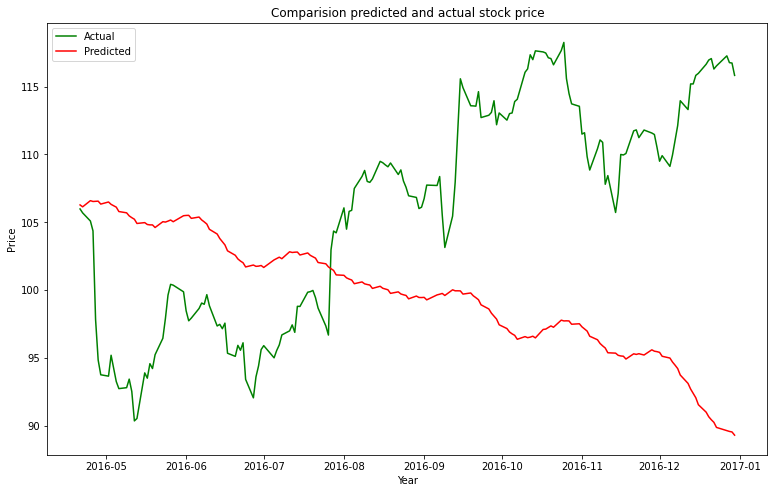

In [11]:
actual_data, prediction_data = predict_prophet(prophet_data, 177)

# calc MAE expected and predicted values
mse = mean_squared_error(actual_data['y'], prediction_data['yhat'])
print('MSE: %.3f' % mse)

plot_comparison_graph("Comparision predicted and actual stock price",
                      actual_data['ds'], 
                      actual_data['y'],
                      prediction_data['ds'],
                      prediction_data['yhat']
                     )

MSE: 270.469


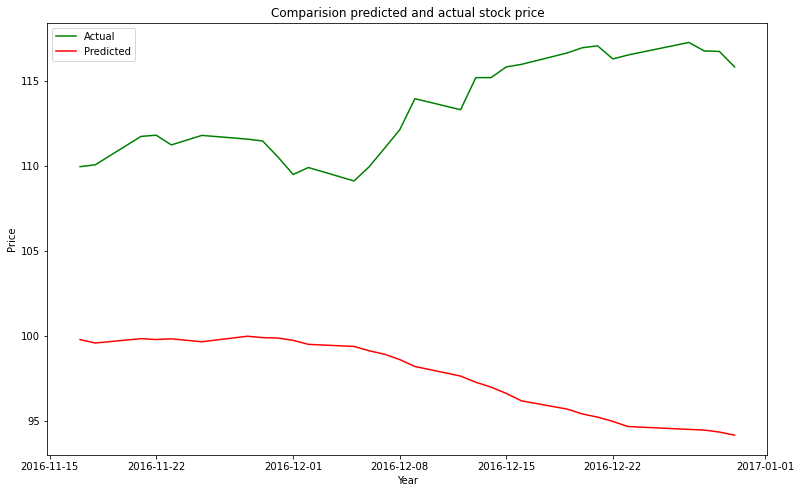

In [12]:
actual_data, prediction_data = predict_prophet(prophet_data, 30)

# calc MAE expected and predicted values
mse = mean_squared_error(actual_data['y'], prediction_data['yhat'])
print('MSE: %.3f' % mse)

plot_comparison_graph("Comparision predicted and actual stock price",
                      actual_data['ds'], 
                      actual_data['y'],
                      prediction_data['ds'],
                      prediction_data['yhat']
                     )

# Recurrent Neural Network

### Prepare the data

In [29]:
def prepare_rnn_data(dataframe, column_count, split_factor):
    # Split the data into training and test and extract the close columns values
    lstm_train = dataframe
    lstm_train_data = lstm_train.iloc[:, 1:column_count+1].values

    split_count = int((split_factor * int(len(lstm_train_data))))

    # Scale the values with MinMaxScaler
    scaler = MinMaxScaler(feature_range = (0,1))

    # Step-Size - 1 for every day
    step = 1

    # Use the last 90 market days to predict 30 days of future
    past = 90
    future = 30
    batch_size = 1

    # Normalize the Train Data
    lstm_train_scaled_complete = scaler.fit_transform(lstm_train_data)
    lstm_train_scaled_complete = pd.DataFrame(lstm_train_scaled_complete)

    # Split Train data into Train/Validation
    lstm_train_scaled_train = lstm_train_scaled_complete.loc[0:split_count-1]
    lstm_train_scaled_validation = lstm_train_scaled_complete.loc[split_count:]

    start = past + future
    end = start + split_count
    sequence_length = int(past / step)   


    x_train = lstm_train_scaled_train[[i for i in range(column_count)]].values
    y_train = lstm_train_scaled_complete.iloc[start:end][[0]]

    # Train dataset
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x_train,
        y_train,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

    # Validation Dataset
    x_end = len(lstm_train_scaled_validation) - past - future

    label_start = split_count + past + future

    x_val = lstm_train_scaled_validation.iloc[:x_end][[i for i in range(column_count)]].values
    y_val = lstm_train_scaled_complete.iloc[label_start:][[0]]

    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x_val,
        y_val,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    
    return dataset_train, dataset_val, scaler

def predict_and_plot_forecast_lstm(dataset_val, model, scaler):
    # Take the last Timestep to predict 30 days into the future
    for x, y in dataset_val.skip(len(dataset_val)-1):
        prediction = model.predict(x)[0]
        prediction = np.reshape(prediction,(-1,1))
        prediction_inverse = scaler.inverse_transform(prediction)
        actual_value = np.reshape(y,(-1,1))
        actual_value = scaler.inverse_transform(actual_value)
        history = np.reshape(x,(-1,1))
        history = scaler.inverse_transform(history)
        show_comparison_plot(
            [history, actual_value, prediction_inverse],
            30,
            "Predict 30 Days into the Future",
        )
        mse = mean_squared_error(actual_value, prediction_inverse)
        print('MSE: %.3f' % mse)
        return

def predict_and_plot_multicolumn_forecast_lstm(dataset_val, model, scaler):
    # Adjust scaler
    newScaler = MinMaxScaler()
    newScaler.min_,newScaler.scale_ = scaler.min_[0],scaler.scale_[0]
    # Take the last Timestep to predict 30 days into the future
    for x, y in dataset_val.skip(len(dataset_val)-1):
        prediction = model.predict(x)[0]
        prediction = np.reshape(prediction,(-1,1))
        prediction_inverse = newScaler.inverse_transform(prediction)[:, [0]]
        actual_value = np.reshape(y,(-1,1))
        actual_value = newScaler.inverse_transform(actual_value)[:, [0]]
        history = np.reshape(x,(-1,5))
        history = newScaler.inverse_transform(history)[:, [0]]
        show_comparison_plot(
            [history, actual_value[0], prediction_inverse[0]],
            30,
            "Predict 30 Days into the Future",
        )
        mse = mean_squared_error(actual_value, prediction_inverse)
        print('MSE: %.3f' % mse)
        return

# Simple Recurrent Neural Network

In [30]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 10

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(SimpleRNN(32, input_shape = (inputs.shape[1], inputs.shape[2]), recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Compile
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 32)                1088      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0161 - val_loss: 0.0270
Epoch 2/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0060 - val_loss: 0.0216
Epoch 3/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0070 - val_loss: 0.0206
Epoch 4/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0069 - val_loss: 0.0201
Epoch 5/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0072 - val_loss: 0.0208
Epoch 6/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0074 - val_loss: 0.0193
Epoch 7/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0071 - val_loss: 0.0202l
Epoch 8/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0078 - val_loss: 0.0184
Epoch 9/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.0074 - val_loss: 0.0210
Epoch 10/10
1320/1320 [==============================] - 9s 7ms/step - loss: 0.00

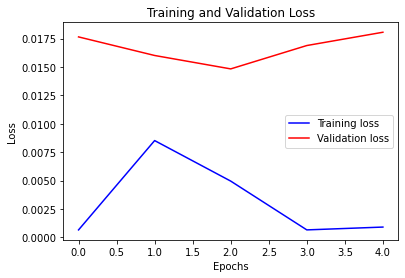

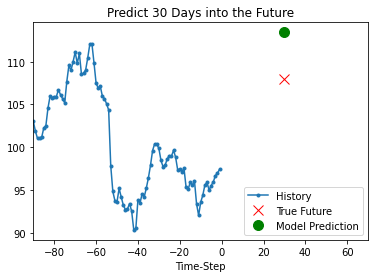

MSE: 29.254


In [28]:
visualize_loss(history, "Training and Validation Loss")
predict_and_plot_forecast_lstm(dataset_val, model, scaler)

# GRU

In [34]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 10

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(GRU(32, input_shape = (inputs.shape[1], inputs.shape[2]), recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# Compile
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3360      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0029 - val_loss: 0.0226
Epoch 2/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0091 - val_loss: 0.0212
Epoch 3/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0074 - val_loss: 0.0199
Epoch 4/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0057 - val_loss: 0.0193
Epoch 5/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0060 - val_loss: 0.0195
Epoch 6/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0056 - val_loss: 0.0176
Epoch 7/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0052 - val_loss: 0.0179
Epoch 8/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0052 - val_loss: 0.0187
Epoch 9/10
1320/1320 [==============================] - 37s 28ms/step - loss: 0.0054 - val_loss: 0.0173
Epoch 10/10
1320/1320 [==============================] - 37s 28m

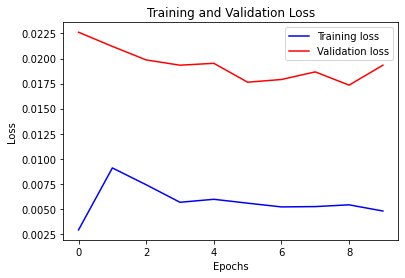

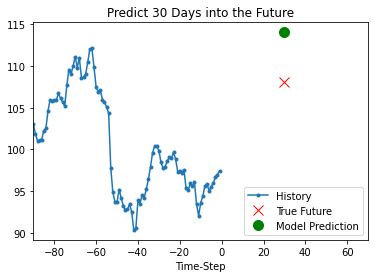

MSE: 36.164


In [36]:
visualize_loss(history, "Training and Validation Loss")
predict_and_plot_forecast_lstm(dataset_val, model, scaler)

# Long short-term memory (LSTM)

## One Layer LSTM
A simple LSTM with one column. It uses the close prices of the last 90 days to predict 30 days into the future.
For this setup we will use the close price of every day only. After we compared this basic approach we will try and add all columns to the LSTM to compare the perfomrance against the basic LSTM that uses only one column.

In [14]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 5

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(LSTM(units=32, input_shape = (inputs.shape[1], inputs.shape[2])))

# Output Layer
model.add(Dense(units = 1))

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                4352      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fitting the neural network to the training set
history = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/5
1320/1320 [==============================] - 14s 11ms/step - loss: 9.9670e-04 - val_loss: 0.0076
Epoch 2/5
1320/1320 [==============================] - 14s 10ms/step - loss: 0.0013 - val_loss: 0.0073
Epoch 3/5
1320/1320 [==============================] - 14s 10ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 4/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0020 - val_loss: 0.0056
Epoch 5/5
1320/1320 [==============================] - 14s 11ms/step - loss: 0.0022 - val_loss: 0.0050


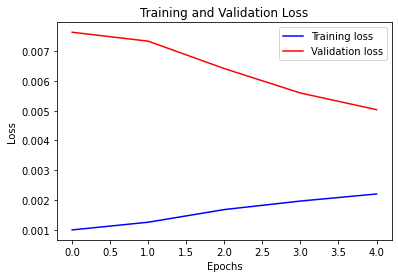

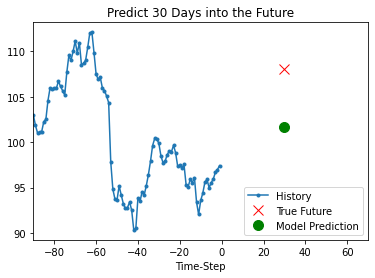

MSE: 40.972


In [16]:
visualize_loss(history, "Training and Validation Loss")
predict_and_plot_forecast_lstm(dataset_val, model, scaler)

### Multi Layer LSTM


In [17]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_date_close, 1, 0.8)

learning_rate = 0.001
epochs = 5

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(LSTM(units=32, return_sequences=True, input_shape = (inputs.shape[1], inputs.shape[2])))
model.add(Dropout(0.5))

# 2 Layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))

# 3 Layer
model.add(LSTM(units=32))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units = 1))

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error")

# Fitting the neural network to the training set
#history_complex = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)
history_complex = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/5
1320/1320 [==============================] - 44s 33ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 2/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0074 - val_loss: 0.0167
Epoch 3/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0089 - val_loss: 0.0074
Epoch 4/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0106 - val_loss: 0.0085
Epoch 5/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0112 - val_loss: 0.0082


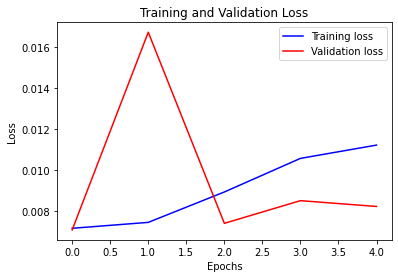

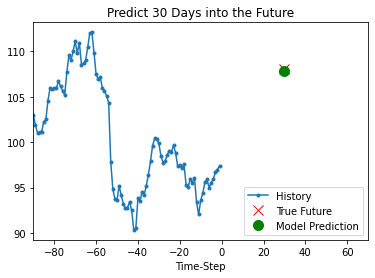

MSE: 0.037


In [18]:
visualize_loss(history_complex, "Training and Validation Loss")
predict_and_plot_forecast_lstm(dataset_val, model, scaler)

## Multi Layer LSTM with multiple Data Columns

In [19]:
print(stock_df_complete.head())

           date      close       open        low       high       volume
254  2010-01-04  30.572857  30.490000  30.340000  30.642857  123432400.0
721  2010-01-05  30.625713  30.657143  30.464285  30.798571  150476200.0
1189 2010-01-06  30.138571  30.625713  30.107143  30.747143  138040000.0
1657 2010-01-07  30.082857  30.250000  29.864286  30.285715  119282800.0
2125 2010-01-08  30.282858  30.042856  29.865715  30.285715  111902700.0


In [20]:
dataset_train, dataset_val, scaler = prepare_rnn_data(stock_df_complete, 5, 0.8)

learning_rate = 0.001
epochs = 5

for batch in dataset_train.take(1):
    inputs, targets = batch

model = keras.Sequential()

# 1 Layer
model.add(LSTM(units=32, return_sequences=True, input_shape = (inputs.shape[1], inputs.shape[2])))
model.add(Dropout(0.5))

# 2 Layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.5))

# 3 Layer
model.add(LSTM(units=32))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units = 1))

# Compile
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mean_squared_error")

# Fitting the neural network to the training set
#history_complex = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)
history_complex_multi_column = model.fit(dataset_train,epochs=epochs,validation_data=dataset_val)

Epoch 1/5
1320/1320 [==============================] - 43s 33ms/step - loss: 0.0050 - val_loss: 0.0183
Epoch 2/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0053 - val_loss: 0.0096s - loss: 0.0 - ETA 
Epoch 3/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0054 - val_loss: 0.0068
Epoch 4/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0040 - val_loss: 0.0112
Epoch 5/5
1320/1320 [==============================] - 42s 32ms/step - loss: 0.0042 - val_loss: 0.0129s: - ETA: 0s - los


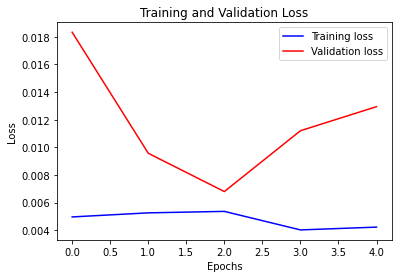

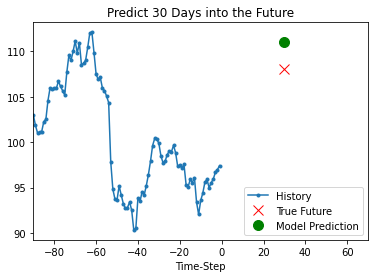

MSE: 8.889


In [21]:
visualize_loss(history_complex_multi_column, "Training and Validation Loss")
predict_and_plot_multicolumn_forecast_lstm(dataset_val, model, scaler)

# Summary